In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import plotly.figure_factory as ff
# plotly express
import plotly.express as px

from itertools import combinations
from functools import partial

import scipy
from scipy.stats import wasserstein_distance
from scipy.stats.mstats import ks_twosamp
from scipy.special import kl_div
from scipy.spatial.distance import jensenshannon

sns.set_theme(style="whitegrid", palette="pastel")
np.random.seed(0)

# This notebook aims to 📊 visualize different drift measures
- Reference:
  - [A hands-on introduction to drift metrics](https://superwise.ai/blog/a-hands-on-introduction-to-drift-metrics/)

# Constants

In [2]:
SAMPLE_SIZE = 1000
BINS=np.linspace(-10.0, 10.0, num=1000) #in order for 2 different distributions to be comparable we need to convert them to histograms using the same bins

# Utils

code from: https://stackoverflow.com/questions/18425225/getting-the-name-of-a-variable-as-a-string

In [3]:
import inspect
def retrieve_name(var):
        """
        Gets the name of var. Does it from the out most frame inner-wards.
        :param var: variable to get name from.
        :return: string
        """
        for fi in reversed(inspect.stack()):
            names = [var_name for var_name, var_val in fi.frame.f_locals.items() if var_val is var]
            if len(names) > 0:
                return names[0]


## Binning Strategies

- Relying on some code from https://github.com/mwburke/population-stability-index used also to calculate psi
- Binning strategy can change you results in drift because it affects your estimated PDF, we will visualize a concrete difference between quantiles and linspace bins.
- in this specific example what we change is how we determine the breakpoints, another parameter that can affect the results a lot is the number of breakpoints.

In [4]:
sample = np.random.normal(0, 1, 10000)
sample_2 = np.random.normal(1,0.5,10000)

In [5]:
# Scales input to [min,max]
def _scale_range(input, lower, upper):
  """Scales the values in an input array to a specified range.

  This function takes an input array and scales its values to a specified range
  (between `lower` and `upper`), ensuring that the minimum and maximum values of
  the input array are mapped to the specified minimum and maximum values of the
  output range.

  Args:
      input: The input array.
      lower: The minimum value of the desired output range.
      upper: The maximum value of the desired output range.

  Returns:
      The scaled input array.
  """
  output = input.copy()
  output += -(np.min(output))
  output /= np.max(output) / (upper - lower)
  output += lower
  return output

In [6]:
num_of_buckets = 10

# breakpoints = [  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]
breakpoints = np.arange(0, num_of_buckets + 1) / (num_of_buckets) * 100
# scale the breakpoints into the range(min(sample), max(sample))
breakpoints_bins = _scale_range(breakpoints.copy(), np.min(sample), np.max(sample))
# create the breakpoints based on the percentile of the sample
breakpoints_quantiles = np.array([np.percentile(sample, b) for b in breakpoints])

In [7]:
breakpoints

array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.])

In [8]:
breakpoints_bins

array([-3.74010064, -2.98592455, -2.23174847, -1.47757238, -0.7233963 ,
        0.03077979,  0.78495587,  1.53913196,  2.29330804,  3.04748413,
        3.80166021])

In [9]:
breakpoints_quantiles

array([-3.74010064, -1.30023361, -0.8562671 , -0.53174781, -0.26388972,
       -0.0270726 ,  0.21847815,  0.49102476,  0.81098307,  1.2546345 ,
        3.80166021])

In [10]:
counts, bins = np.histogram(sample, breakpoints_bins)

In [11]:
counts

array([  10,  110,  579, 1710, 2833, 2688, 1479,  487,   97,    7])

In [12]:
bins

array([-3.74010064, -2.98592455, -2.23174847, -1.47757238, -0.7233963 ,
        0.03077979,  0.78495587,  1.53913196,  2.29330804,  3.04748413,
        3.80166021])

In [13]:
def plot_hist(sample,breakpoints):
  counts, bins = np.histogram(sample, breakpoints)
  bins = 0.5 * (bins[:-1] + bins[1:])
  fig = px.bar(x=bins, y=counts, labels={'y': 'count'})
  fig.show()

In [14]:
plot_hist(sample,breakpoints_bins)

In [15]:
plot_hist(sample, breakpoints_quantiles)

- Choosing the breakpoint based on the percentile, each bin will have the same number of counts.

- In order to calculate drift we need both distributions to use the same bins/breakpoints, lets see how using each of these bins to sample a slightly shifted distribution

In [16]:
plot_hist(sample_2,breakpoints_bins)

In [17]:
plot_hist(sample_2, breakpoints_quantiles)

## Create Samples
We will create the following samples drawn from known parameterized distributions.

You can swap these with numeric feature samples from your dataset.
- Continous distributions: Normal, uniform, and lognormal
- Discrete distributions: multinomial

In [18]:
# continious/numerical samples
normal_0_2 = np.random.normal(0,2,SAMPLE_SIZE)
normal_01_1 = np.random.normal(0.1,1,SAMPLE_SIZE)
normal_0_1 = np.random.normal(0,1,SAMPLE_SIZE)
normal_1_1 = np.random.normal(1,1,SAMPLE_SIZE)
normal_0_0 = np.random.normal(0,0,SAMPLE_SIZE)
normal_0_1 = np.random.normal(0,1,SAMPLE_SIZE)
normal_1_0 = np.random.normal(1,0,SAMPLE_SIZE)

# uniform distribution
uniform_0_1 = np.random.uniform(0,1,size=SAMPLE_SIZE)
uniform_0_2 = np.random.uniform(0,2,size=SAMPLE_SIZE)

# log normal
lognormal_0_1 = np.random.lognormal(0,1,size=SAMPLE_SIZE)
lognormal_1_1 = np.random.lognormal(0,1,size=SAMPLE_SIZE)
lognormal_0_2 = np.random.lognormal(0,1,size=SAMPLE_SIZE)

# numerical with small values of unique values / "categorical" samples
def multinomial_to_observation(arr):
  ret = []
  for i in range(len(arr)):
    ret.extend([i]*arr[i])
  return np.asarray(ret,dtype=float)

cat_uniform_6 = multinomial_to_observation(np.random.multinomial(SAMPLE_SIZE, [1/6.]*6))
cat_tilted_mid = multinomial_to_observation(np.random.multinomial(SAMPLE_SIZE, ([1/14.]*3)+[4/7.]+([1/14.]*3)))
cat_tilted_right = multinomial_to_observation(np.random.multinomial(SAMPLE_SIZE, ([1/14.]*6)+[4/7.]))
cat_tilted_left = multinomial_to_observation(np.random.multinomial(SAMPLE_SIZE, [4/7.]+([1/14.]*6)))
cat_uniform_2 = multinomial_to_observation(np.random.multinomial(SAMPLE_SIZE, ([1/2.0]*2)))
cat_uniform_3 = multinomial_to_observation(np.random.multinomial(SAMPLE_SIZE, [1/3.]*3))
cat_uniform_4 = multinomial_to_observation(np.random.multinomial(SAMPLE_SIZE, [1/4.]*4))
cat_uniform_5 = multinomial_to_observation(np.random.multinomial(SAMPLE_SIZE, [1/5.]*5))
cat_uniform_7 = multinomial_to_observation(np.random.multinomial(SAMPLE_SIZE, [1/7.]*7))
cat_uniform_8 = multinomial_to_observation(np.random.multinomial(SAMPLE_SIZE, [1/8.]*8))
cat_uniform_9 = multinomial_to_observation(np.random.multinomial(SAMPLE_SIZE, [1/9.]*9))
cat_uniform_10 = multinomial_to_observation(np.random.multinomial(SAMPLE_SIZE, [1/10.]*10))

cat_names = ["cat_uniform_6",
  "cat_tilted_mid",
  "cat_tilted_right",
  "cat_tilted_left",
  "cat_uniform_2",
  "cat_uniform_3",
  "cat_uniform_4",
  "cat_uniform_5",
  "cat_uniform_7",
  "cat_uniform_8",
  "cat_uniform_9",
  "cat_uniform_10"
]

In [19]:
samples = [normal_0_2,normal_01_1,normal_0_0,normal_0_1,normal_1_0,normal_1_1
           ,uniform_0_1,uniform_0_2,lognormal_0_1,lognormal_1_1,lognormal_0_2
           ,cat_uniform_6,cat_uniform_2,cat_uniform_3,
           cat_uniform_4,cat_uniform_5,cat_uniform_7,cat_uniform_8,cat_uniform_9,cat_uniform_10,cat_tilted_mid,cat_tilted_right,cat_tilted_left]

## Statistical Distance Measures

### PSI Population Stability Index

- Code from https://github.com/mwburke/population-stability-index
- Practitioners have proposed domain thresholds to make a decision using the PSI indicator (Siddiqi, 2005):
  - `PSI < 0.1`: no significant population change
  - `0.1 < PSI < 0.2`: moderate population change
  - `PSI > 0.2`: significant population change
- **PSI bins** and **PSI quantiles** (calculating the same metric with 2 different binning strategies)

In [20]:
def calculate_psi(expected, actual, bucket_type='bins', buckets=10, axis=0):
    '''Calculate the PSI (population stability index) across all variables

    Args:
       expected: numpy matrix of original values
       actual: numpy matrix of new values, same size as expected
       bucket_type: type of strategy for creating buckets, bins splits into even splits, quantiles splits into quantile buckets
       buckets: number of quantiles to use in bucketing variables
       axis: axis by which variables are defined, 0 for vertical, 1 for horizontal

    Returns:
       psi_values: ndarray of psi values for each variable

    Author:
       Matthew Burke
       github.com/mwburke
       worksofchart.com
    '''

    def psi(expected_array, actual_array, buckets):
        '''Calculate the PSI for a single variable

        Args:
           expected_array: numpy array of original values
           actual_array: numpy array of new values, same size as expected
           buckets: number of percentile ranges to bucket the values into

        Returns:
           psi_value: calculated PSI value
        '''
        def scale_range(input, lower, upper):
            input += -(np.min(input))
            input /= np.max(input) / (upper - lower)
            input += lower
            return input

        def count_per_bin(arr, breakpoint_list):
            counts, bins = np.histogram(arr, breakpoint_list)
            return counts

        def sub_psi(e_perc, a_perc,  eps = 1e-4):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            # If a_perc or e_perc is zero, this will cause the error in log(a_perc/e_perc)
            # Hence, we will assign
            if a_perc == 0:
                a_perc = eps
            if e_perc == 0:
                e_perc = eps

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return value

        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if bucket_type == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif bucket_type == 'quantiles':
            breakpoints = np.array([np.percentile(expected_array, b) for b in breakpoints])

        expected_percents = count_per_bin(expected_array, breakpoints) / len(expected_array)
        actual_percents = count_per_bin(actual_array, breakpoints) / len(actual_array)

        psi_value = sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

        return psi_value

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        # if inputs are multiple columns, psi_values will be a list of psi values
        psi_values = np.empty(expected.shape[axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return psi_values




psi_bins = partial(calculate_psi, bucket_type="bins")
psi_quantiles = partial(calculate_psi, bucket_type="quantiles")

0.0001

In [21]:
rs = np.random.RandomState(5)

initial = rs.normal(size = 100)
new = rs.normal(loc = 0.2, size = 120)

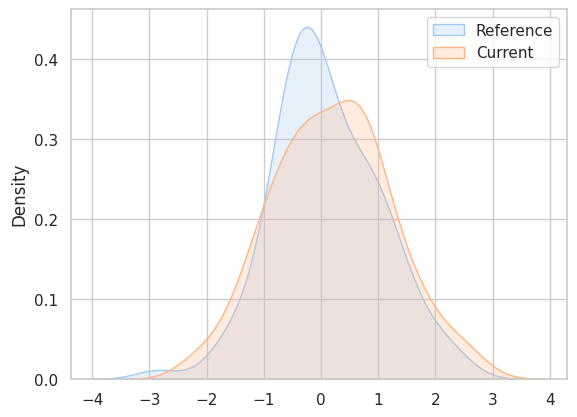

In [22]:
fig, ax = plt.subplots()
sns.kdeplot(initial, fill=True, label="Reference", ax=ax)
sns.kdeplot(new, fill=True, label="Current",ax=ax)


# sns.despine(left=True)
# ax.set(yticklabels=[], xticklabels = [])
plt.legend()
plt.show()

In [23]:
buckets = 10
raw_breakpoints = np.arange(0, buckets + 1) / (buckets) * 100
breakpoints = _scale_range(raw_breakpoints, np.min(initial), np.max(initial))

initial_counts = np.histogram(initial, breakpoints)[0]
new_counts = np.histogram(new, breakpoints)[0]

df = pd.DataFrame({'Bucket': np.arange(1, 11), 'Breakpoint Value':breakpoints[1:], 'Initial Count':initial_counts, 'New Count':new_counts})
df['Initial Percent'] = df['Initial Count'] / len(initial)
df['New Percent'] = df['New Count'] / len(new)

df['New Percent'][df['New Percent'] == 0] = 0.00001
df

,Bucket,Breakpoint Value,Initial Count,New Count,Initial Percent,New Percent
0,1,-2.330642,1,0,0.01,0.000010
1,2,-1.801596,1,3,0.01,0.025000
2,3,-1.272550,4,6,0.04,0.050000
3,4,-0.743504,8,15,0.08,0.125000
4,5,-0.214458,27,18,0.27,0.150000
5,6,0.314588,22,23,0.22,0.191667
6,7,0.843633,16,26,0.16,0.216667
7,8,1.372679,12,14,0.12,0.116667
8,9,1.901725,6,9,0.06,0.075000
9,10,2.430771,3,3,0.03,0.025000


$PSI = \sum{}\Big(\big(Actual \% - Expected \%\big) \times ln\big(\dfrac{Actual \%}{Expected \%}\big)\Big)$

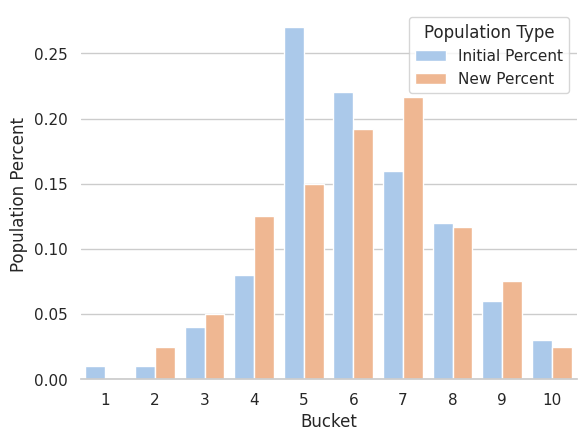

In [24]:
df_melted=df.melt(id_vars=['Bucket'],
        value_vars=['Initial Percent', 'New Percent'],
        var_name='Population Type',
        value_name='Percent')
ax = sns.barplot(df_melted, x='Bucket', y='Percent', hue='Population Type')
ax.set(ylabel="Population Percent")
sns.despine(left=True)
plt.show()


In [25]:
df['PSI'] = (df['New Percent'] - df['Initial Percent']) * np.log(df['New Percent'] / df['Initial Percent'] )

In [26]:
np.sum(df['PSI'])

0.2010411206240184

In [27]:
np.round(psi_bins(initial, new, buckets=10), 5) == np.round(np.sum(df['PSI']), 5)

False

In [28]:
# percentile:
breakpoints_percentile = np.array([np.percentile(initial, b) for b in raw_breakpoints])

initial_counts = np.histogram(initial, breakpoints_percentile)[0]
new_counts = np.histogram(new, breakpoints_percentile)[0]

df = pd.DataFrame({'Bucket': np.arange(1, 11), 'Breakpoint Value':breakpoints[1:], 'Initial Count':initial_counts, 'New Count':new_counts})
df['Initial Percent'] = df['Initial Count'] / len(initial)
df['New Percent'] = df['New Count'] / len(new)

df['New Percent'][df['New Percent'] == 0] = 0.00001
df

,Bucket,Breakpoint Value,Initial Count,New Count,Initial Percent,New Percent
0,1,-2.330642,10,20,0.1,0.166667
1,2,-1.801596,10,8,0.1,0.066667
2,3,-1.272550,10,6,0.1,0.050000
3,4,-0.743504,10,8,0.1,0.066667
4,5,-0.214458,10,9,0.1,0.075000
5,6,0.314588,10,9,0.1,0.075000
6,7,0.843633,10,14,0.1,0.116667
7,8,1.372679,10,17,0.1,0.141667
8,9,1.901725,10,13,0.1,0.108333
9,10,2.430771,10,13,0.1,0.108333


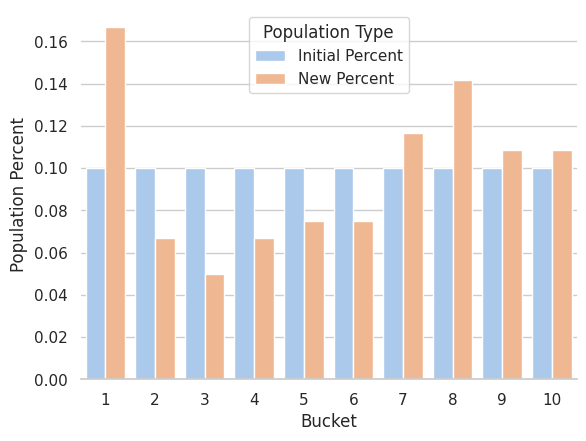

In [29]:
df_melted=df.melt(id_vars=['Bucket'],
        value_vars=['Initial Percent', 'New Percent'],
        var_name='Population Type',
        value_name='Percent')
ax = sns.barplot(df_melted, x='Bucket', y='Percent', hue='Population Type')
ax.set(ylabel="Population Percent")
sns.despine(left=True)
plt.show()

In [30]:
df['PSI'] = (df['New Percent'] - df['Initial Percent']) * np.log(df['New Percent'] / df['Initial Percent'] )

In [31]:
np.sum(df['PSI'])

0.1285435134950522

In [32]:
print(psi_bins(initial, new, buckets=10))
print(psi_quantiles(initial, new, buckets=10))

0.177623830228269
0.12854351349505216


## $Χ^2$
- **Pearson’s Chi-Square distance**: Pearson’s Chi-Square distance used in the Chi-Square test measures whether there is a statistically significant difference between two distributions.
$$dist(P,Q)= \frac{1}{2}\sum_i{\frac{(P(i) - Q(i))^2}{P(i) + Q(i)}} $$

In [33]:
# Scales input to [0,1]
def scale_range(input):
  input += -(np.min(input))
  input = np.divide(input.astype(float), np.max(input).astype(float),out=np.zeros_like(input).astype(float) ,where = input!=0)
  return input

In [34]:
# Takes a sample of observations as input and returns bins(constant) and frequency which is normalized to [0,1]
def get_prob_vec_from_sample(x):
  prob, bins = np.histogram(x, bins=BINS)
  prob = scale_range(prob)
  # prob[np.where(prob==0)]=np.finfo(float).eps # some of the drift measures explode/become infinity when the value is 0 so we swap it with epsilon to get a big value instead of division by zero
  return prob, bins

In [35]:
def chi_square_distance(d1, d2):
  prob1 = get_prob_vec_from_sample(d1)[0]
  prob2 = get_prob_vec_from_sample(d2)[0]
  a = prob1 - prob2
  b = prob1 + prob2
  return float(((np.divide(a * a, b, out=np.zeros_like(a), where=b != 0)).sum() / 2))

In [55]:
    a = [1, 2, 13, 5, 45, 23]
    b = [67, 90, 18, 79, 24, 98]

    result = chi_square_distance(a, b)
    print("The Chi-square distance is :", result)

The Chi-square distance is : 1.5


- **Pearson’s chi-squared test** (test of independence) is a hypothesis test that is used to determine whether there is a significant association between two categorical variables in the data. The test involves two hypotheses ($H_0$ & $H_1$):
  - $H_0$: The two categorical variables have no relationship (independent)
  - $H_1$: There is a relationship (dependent) between two categorical variables
- However, it requires a relatively large sample size, and it is difficult to interpret when there are large numbers of categories (20 or more)
- Reference: [Beginner’s guide to Chi-square Test in Python from Scratch](https://analyticsindiamag.com/a-beginners-guide-to-chi-square-test-in-python-from-scratch/)
  - P-value is used as a measure of evidence against the null hypothesis.
    - If it is greater than our level of significance (alpha=0.05) then we will accept our null hypothesis

In [36]:
np.random.seed(10)
# Sample data randomly at fixed probabilities
type_bottle = np.random.choice(a= ["paper","cans","glass","others","plastic"],
                              p = [0.05, 0.15 ,0.25, 0.05, 0.5],
                              size=SAMPLE_SIZE)

# Sample data randomly at fixed probabilities
month = np.random.choice(a= ["January","February","March"],
                              p = [0.4, 0.2, 0.4],
                              size=1000)

bottles = pd.DataFrame({"types":type_bottle,
                       "months":month})

In [37]:
bottles.head()

,types,months
0,plastic,January
1,paper,March
2,plastic,February
3,plastic,March
4,others,January


- The Contingency table (also called crosstab) is used in statistics to summarise the relationship between several categorical variables.
  - In this example, we are taking a table that shows the number of bottle `types` for each month in the `months` column.

In [38]:
bottles_tab = pd.crosstab(bottles.types, bottles.months, margins = True)

#Rename the columns and row index
bottles_tab.columns = [*bottles_tab.columns.to_list()[:-1], 'row_totals']
bottles_tab.index = [*bottles_tab.index.to_list()[:-1], 'col_totals']

observed = bottles_tab.iloc[0:5,0:3]   # Get table without totals for later use
bottles_tab

,February,January,March,row_totals
cans,25,65,64,154
glass,50,107,94,251
others,8,15,15,38
paper,7,21,32,60
plastic,96,189,212,497
col_totals,186,397,417,1000


In [39]:
observed

,February,January,March
cans,25,65,64
glass,50,107,94
others,8,15,15
paper,7,21,32
plastic,96,189,212


- Expected Values Table: Multiply the row total to the column total and divide by the total number of observations for a cell to get the expected count. So, to calculate the expected counts in python we need to use the `np.outer() `function on row total and column total. At last, dividing the output of the `np.outer()` function by total observation.

In [40]:
# how to calculate the expected values
expected =  np.outer(bottles_tab["row_totals"][0:5],
                     bottles_tab.loc["col_totals"][0:3]) / SAMPLE_SIZE

expected = pd.DataFrame(expected,
                        columns=bottles_tab.columns.to_list()[:-1],
                        index=bottles_tab.index.to_list()[:-1])
expected

,February,January,March
cans,28.644,61.138,64.218
glass,46.686,99.647,104.667
others,7.068,15.086,15.846
paper,11.160,23.820,25.020
plastic,92.442,197.309,207.249


- Chi-Square Table:
$$ \frac{(Observed - Expected)^2}{Expected} $$

  - The chi-square static value is the sum of values in the Chi-Square table.

In [41]:
# .sum() twice, once to get the column sums and a second time to add the column sums together,
# returning the sum of the entire 2D table.
chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()
print(chi_squared_stat)


7.169321280162059


In [42]:
from scipy.stats import chi2

- calculate the `p-value` and `critical value` which will help to accept or reject the null hypothesis
- The degrees of freedom for a test of independence equals the product of the number of categories in each variable minus 1. (i.e.: df = (r-1)(c-1)) In this case we have a 5×3 table so df = 4×2 = 8

In [43]:
critical_value = chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 8)   # df= degree of freedom

print(f"Critical value: {critical_value}")


p_value = 1 - chi2.cdf(x=chi_squared_stat,  # Find the p-value
                             df=8)
print(f"P value: {p_value}")


Critical value: 15.50731305586545
P value: 0.518479392948842


In [44]:
# In the above explanations, we have seen how does chi-square test work.
# It can be done by a quick method by just a single line of code
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(observed)

# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')


p value is 0.518479392948842
Independent (H0 holds true)


- Finally, we get a p-value of 0.51847 which is greater than 0.5. Therefore, we will accept the null hypothesis that says there is no relationship between the features

#### Yate's correction
- Yate corrected Pearson’s chi-square formula by subtracting the difference of the observed and expected value by 0.5 and the rest is the same as the previous.

To use Yate’s chi-square test, we can write the following line of code:  

In [45]:
# "correction=True" to apply Yates' correction
result = chi2_contingency(observed=observed, correction=True)

In [46]:
result.pvalue

0.518479392948842

## Kullback–Leibler divergence
- Kullback Leibler (KL) divergence, also known as **relative entropy**, measures how well two distributions match or differ from each other.
- Formula (discrete form):
 $$KL\left(Q||P\right)=-\sum_{x}^{}P\left(x\right)\cdot log\left(\frac{Q(x)}{P(x)}\right)$$
- Usage: one distribution has a high variance relative to another or small sample size.
  - In model monitoring, most practitioners almost exclusively use the discrete form of KL divergence and obtain the discrete distributions by **binning** data. (i.e.: numerical feature -> binning -> KL discrete form, categorical feature -> directly KL discrete form)
    - KL divergence is used to monitor production environments, specifically around feature and prediction data.
    - KL Divergence is utilized to ensure that input or output data in production doesn’t drastically change from a baseline.
    - The baseline can be a training production window of data or a training or validation dataset.
  - KL divergence is typically applied to each feature independently
- Range: $KL \in [0,\infty)$
  - When KL=0, it means that the two distributions are identical.
- Similar to PSI, it has its basis in information theory. One important difference from PSI is that KL Divergence is not symmetric.
  - Meaning that $KL(Q||P) \neq KL(P||Q)$ unless they are equal.
  - Asymmetry is especially useful when you have a large number of samples for a reference distribution, and a very small set of samples (resulting in more variance) in the comparison distribution.

In [47]:
def kl(d1,d2):
  prob1 = get_prob_vec_from_sample(d1)[0]
  prob2 = get_prob_vec_from_sample(d2)[0]
  return sum(kl_div(prob1,prob2))

## Jensen Shannon
- Jensen-Shannon divergence is a symmetric measure that uses a **bounded** variant of KL to quantify the difference between two distributions.
- Forumla (discrete form):

$$JSD\left(Q||P\right)=\frac{1}{2}\cdot\left(KL\left(Q||M\right)+KL\left(P||M\right)\right)$$

- Where $M=\frac{1}{2}\left(P+Q\right)$
- Usage: In model monitoring, the discrete form of JS divergence is typically used to obtain the discrete distributions by **binning** data (i.e: continous variables will be binning first before using the JS discrete form)
- Range: Unlike KL divergence, JS always has a finite value (bounded between 0 and 1)



In [48]:
def jensenshannon_base2(d1,d2):
  prob1 = get_prob_vec_from_sample(d1)[0]
  prob2 = get_prob_vec_from_sample(d2)[0]
  return jensenshannon(prob1,prob2,base=2)

## Wasserstein Distance
- Wasserstein distance, also known as the Earth Mover’s distance, measures the distance between two probability distributions for a given region.
- Given 2 sampled distributions binned into n bins, we can compute Earth Mover’s distance as follows:
  - $EMD_0=0$
  - $EMD_{i+1}=P_i+EMD_i-Q_i$
  - $EMD= \sum_{i=0}^{n}\left|EMD_i\right|$

- Wasserstein distance can’t be computed for categorical/discrete distributions because it assumes that distance between bins exists, which means that changing the order of bins will result in unwanted change in drift

In [49]:
def wasserstein(d1,d2):
  prob1,_bins = get_prob_vec_from_sample(d1)
  prob2 = get_prob_vec_from_sample(d2)[0]
  _bins=(_bins[1:] + _bins[:-1]) / 2
  return wasserstein_distance(_bins,_bins,prob1,prob2)

## Kolmogorov–Smirnov $D_{n,m}$
- KS measures the max difference between the CDF of two sampled distributions.
This measure is used in the Kolmogorov Smirnov test in order to check if 2 samples are drawn from the same distribution. Is non-parametric, meaning we don’t need the parameters of the distributions they were drawn from in order to perform the test.

$$D_{n,m}=sup_x|F_{1,n}(x)-F_{2.m}(x)|$$
where $F_{1,n}(x)$ and $F_{2,m}(x)$ are the empirical distribution function of the first and second samples, respectively, and sup is the supremum function.

In [50]:
def ks(d1,d2):
  return ks_twosamp(d1,d2).statistic

## Define and name drift_functions

In [52]:
drift_functions = [(psi_bins,"psi_bins"),(psi_quantiles,"psi_quantiles"),(chi_square_distance,"chi_square"),(wasserstein,"wasserstein")
,(ks,"ks"),(kl,"kl"),(jensenshannon_base2,"jensenshannon")]

# Calculate drift for each pair of samples from the samples defined above

In [56]:
drifts = []
for s1 in samples:
  for s2 in samples:
    for drift_func, df_name in drift_functions:
      curr = {"s1":retrieve_name(s1),"s2":retrieve_name(s2)}
      curr["value"] = drift_func(s1,s2)
      curr["drift"] = df_name
      drifts.append(curr)

<ipython-input-20-b96ee1ec993c>:33: RuntimeWarning:

divide by zero encountered in scalar divide



In [57]:
drifts_df = pd.DataFrame(drifts)
cat_mask =  drifts_df.s1.isin(cat_names)&drifts_df.s2.isin(cat_names)
pivotted_drifts_df = drifts_df.pivot_table(values="value",columns="drift",index=["s1","s2"])
pivotted_drifts_cat_df = drifts_df[cat_mask].pivot_table(values="value",columns="drift",index=["s1","s2"])
pivotted_drifts_num_df = drifts_df[~cat_mask].pivot_table(values="value",columns="drift",index=["s1","s2"])
pivotted_drifts_df

drift                             chi_square  jensenshannon         kl     ks  \
s1              s2                                                              
cat_tilted_left cat_tilted_left     0.000000       0.000000   0.000000  0.000   
                cat_tilted_mid      0.731371       0.594206   1.943730  0.527   
                cat_tilted_right    0.681400       0.577831   1.775314  0.533   
                cat_uniform_10      3.167822       0.560366   5.997425  0.497   
                cat_uniform_2       0.580063       0.534575        inf  0.330   
...                                      ...            ...        ...    ...   
uniform_0_2     normal_0_2         39.001615       0.704602        inf  0.489   
                normal_1_0         33.137681       0.983027        inf  0.511   
                normal_1_1         16.213330       0.470908  36.355672  0.158   
                uniform_0_1        17.168357       0.560458        inf  0.491   
                uniform_0_2         0.000000       0.000000   0.000000  0.000   

drift                             psi_bins  psi_quantiles  wasserstein  
s1              s2                                                      
cat_tilted_left cat_tilted_left   0.000000       0.000000     0.000000  
                cat_tilted_mid    2.352514       2.062768     1.593594  
                cat_tilted_right  2.171735       1.854082     3.147147  
                cat_uniform_10    0.964646       0.964296     3.156156  
                cat_uniform_2     2.902758       3.081070     1.093093  
...                                    ...            ...          ...  
uniform_0_2     normal_0_2        0.762766       0.759090     1.348348  
                normal_1_0        8.423602       8.283089     0.507207  
                normal_1_1        0.167060       0.167339     0.281702  
                uniform_0_1       3.700991       3.288092     0.481281  
                uniform_0_2       0.000000       0.000000     0.000000  

[529 rows x 7 columns]

# Analyze reanges and precentiles with pandas .describe and box plots

## We can use pandas to describe the different drift methods and from that we can observe that:
- kl and JSD often explode to 1 or infinity
- binning strategy for PSI(others weren't tested here) can change results

In [ ]:
pivotted_drifts_df.describe()

In [ ]:
pivotted_drifts_num_df.describe()

In [ ]:
pivotted_drifts_cat_df.describe()

# Calculate correlation matrix between different measures and visualize the correlations with scatterplots

## Correlation matrix

In [ ]:
pivotted_drifts_df.corr().style.background_gradient()

In [ ]:
pivotted_drifts_cat_df.corr().style.background_gradient()

In [ ]:
pivotted_drifts_num_df.corr().style.background_gradient()

##  Visualize the correlation with scatter plots

specifically notice:
$Χ^2$ and KL categorical
KL and jensenshannon

In [ ]:
fig = px.scatter_matrix(pivotted_drifts_df)
fig.update_layout(font_size=11, width=1200,height=900)
fig.show()

In [ ]:
fig = px.scatter(drifts_df[cat_mask&np.isfinite(drifts_df.value)][drifts_df.drift.isin(["jensenshannon","kl"])].pivot_table(values="value",columns="drift",index=["s1","s2"]),x="kl",y="jensenshannon",trendline="ols")
fig.update_layout(font_size=18, width=800,title=f"rsquared: {px.get_trendline_results(fig).px_fit_results.iloc[0].rsquared}")
fig.show()

In [ ]:
fig = px.scatter(drifts_df[(~cat_mask)&np.isfinite(drifts_df.value)&drifts_df.drift.isin(["chi_square","kl"])].pivot_table(values="value",columns="drift",index=["s1","s2"]),x="kl",y="chi_square",trendline="ols")
fig.update_layout(font_size=18, width=800,title=f"rsquared: {px.get_trendline_results(fig).px_fit_results.iloc[0].rsquared}")
fig.show()

In [ ]:
cat_mask = drifts_df.s1.isin(cat_names)&drifts_df.s2.isin(cat_names)
fig = px.box(drifts_df[~cat_mask], x="drift", y="value")
fig.show()

In [ ]:
fig = px.box(drifts_df[cat_mask], x="drift", y="value")
fig.show()

# Select any of the 2 sampled distibutions defined above to plot them and view the different drift measures between them

In [ ]:
#@title Choose samples: { run: "auto" }
sample1 = 'normal_0_2' #@param ['normal_0_2','normal_01_1','normal_0_1','normal_1_1','uniform_0_1','uniform_0_2','lognormal_0_1','lognormal_1_1','lognormal_0_2','cat_uniform_6','cat_tilted_left','cat_tilted_right','cat_tilted_mid','cat_uniform_2']
sample2 = 'lognormal_0_1' #@param ['normal_0_2','normal_01_1','normal_0_1','normal_1_1','uniform_0_1','uniform_0_2','lognormal_0_1','lognormal_1_1','lognormal_0_2','cat_uniform_6','cat_tilted_left','cat_tilted_right','cat_tilted_mid','cat_uniform_2']

hist_data = [globals()[sample1], globals()[sample2]]

group_labels = [sample1, sample2]

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=.2)
fig.show()

df = drifts_df[((drifts_df.s1==sample1)&(drifts_df.s2==sample2))|((drifts_df.s2==sample1)&(drifts_df.s1==sample2))]
df.pivot_table(values="value",columns="drift",index=["s1","s2"])

# Visualize utilization of distance between bins

In [ ]:
for sample in ['cat_tilted_mid','cat_tilted_left','cat_tilted_right']:

  hist_data = globals()[sample]
  counts, bins = np.histogram(hist_data, bins=range(0, 8, 1))
  bins = bins[:-1]

  fig = px.bar(x=bins, y=counts,labels={"y":"count","x":"value"},title=sample)
  fig.show()
  # group_labels = [sample]

  # Create distplot with custom bin_size
  # fig = px.histogram(hist_data, group_labels)
  # fig.show()

In [ ]:
sample1 = 'cat_tilted_mid'
sample2 = 'cat_tilted_left'
sample3 = 'cat_tilted_right'

group_labels = [sample1, sample2,sample3]

mask = ((drifts_df.s1.isin(group_labels))&(drifts_df.s2.isin(group_labels)))
mask &= drifts_df.value>0

df = drifts_df[mask]
df.pivot_table(values="value",columns="drift",index=["s1","s2"])[["chi_square","wasserstein"]]

# Assuming only normal distribution will allow us to explore how changing its parameters affects the different drift metrics

In [ ]:
normal_samples = []
normal_drift = []
for i in np.linspace(0,5,num=6):
  for j in np.linspace(0,5,num=6):
    curr = {"mean":i,"variance":j,"sample":np.random.normal(i,j,SAMPLE_SIZE)}
    normal_samples.append(curr)

for s1 in normal_samples:
  for s2 in normal_samples:
    for drift_func,df_name in drift_functions:
      curr = {"s1_mean":s1["mean"],"s2_mean":s2["mean"],"s1_variance":s1["variance"],"s2_variance":s2["variance"]
              ,"mean_diff":abs(s1["mean"]-s2["mean"]),"variance_diff":abs(s1["variance"]-s2["variance"])}
      curr["value"] = drift_func(s1["sample"],s2["sample"])
      curr["drift"] = df_name
      normal_drift.append(curr)



normaldrifts_df = pd.DataFrame(normal_drift)


In [ ]:
normaldrifts_df.pivot_table(index=["mean_diff","variance_diff"],columns="drift",values="value")

## Visualize magnitude of drift as a heatmeap where the axis are the size of difference in mean and variance

In [ ]:
for drift_func,df_name in drift_functions:
  fig = px.density_heatmap(normaldrifts_df[normaldrifts_df["drift"]==df_name],x="mean_diff",y="variance_diff",z="value",histfunc="avg",title=df_name)
  fig.update_layout(font_size=18, width=800)
  fig.show()

# Play with the parameters of 2 normal distributions and see the different see how different drift metrics produce

In [ ]:
#@title Choose parameters: { run: "auto" }
mu1 =  0 #@param {type:"slider", min:0, max:10, step:1}
mu2 = 1 #@param {type:"slider", min:0, max:10, step:1}
var1 = 1 #@param {type:"slider", min:1, max:10, step:1}
var2 = 1 #@param {type:"slider", min:1, max:10, step:1}

s1 = np.random.normal(mu1,var1,SAMPLE_SIZE)
s2 = np.random.normal(mu2,var2,SAMPLE_SIZE)

hist_data = [s1,s2]

group_labels = [f"mu:{mu1} var:{var1}",f"mu:{mu2} var:{var2}"]

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=.2)
fig.show()

curr = {"s1":f"mu:{mu1} var:{var1}","s2":f"mu:{mu1} var:{var1}"}
for drift_func,df_name in drift_functions:
  curr[df_name] = drift_func(s1,s2)


pd.DataFrame([curr])